In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [35]:
try:
    from sklearn.datasets import load_boston

    data=load_boston()
    X=pd.DataFrame(data.data, columns=data.feature_names)
    y=pd.Series(data.target)
    print("loaded boston dataset usnig sklearn load_boston")

except:
    from sklearn.datasets import fetch_openml
    boston=fetch_openml(name="boston", version=1, as_frame=True)
    X=boston.data
    y=boston.target.astype(float)
    print("loaded boston dataset using openml fallback")

loaded boston dataset using openml fallback


In [36]:
print("feature shape:", X.shape)
print("target shape:", y.shape)

X.head()

feature shape: (506, 13)
target shape: (506,)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [38]:
# Decision tree from scratch

#treenode decision tree ki ek node ko represent karta hai
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature=feature           #feature to split on
        self.threshold=threshold       #threshold for split
        self.left=left                 #left child node
        self.right=right               #right child node
        self.value=value     

#decsion tree regressor class
class DecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth=max_depth            #hyperparamter: tree ki complexity control karta hai
        self.root=None                     #root node pf tree

    #train tree
    def fit(self, X, y):
        X=X.values if hasattr(X, "values") else X
        y=np.array(y)

        #start recursive tre building
        self.root=self._build_tree(X, y, depth=0)

    #recursive tree func
    def _build_tree(self, X, y, depth):
        if depth>=self.max_depth or len(np.unique(y))==1:  #1st stop condition if maxdepthreached->make leaf node          
            return TreeNode(value=np.mean(y))              #2nd agar sari y values same make leaf node

        #best feature and threshold to split data
        best_feature, best_threshold=self._best_split(X, y)
    
        #agar valid split nhi to make leaf
        if best_feature is None:
            return TreeNode(value=np.mean(y))
    
        #left right mai data split
        left_mask=X[:, best_feature]<=best_threshold
        right_mask=X[:, best_feature]>best_threshold
    
        #recursively left and right banaege
        left_node=self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_node=self._build_tree(X[right_mask], y[right_mask], depth + 1)
    
        return TreeNode(
            feature=best_feature, threshold=best_threshold, left=left_node,right=right_node
        )

    #best using squared error
    def _best_split(self, X, y):
        best_error=float("inf")
        best_feature=None
        best_threshold=None

        #looping through all features
        for feature in range(X.shape[1]):
            thresholds=np.unique(X[:, feature])

            #trying all possible split thresholds
            for t in thresholds:
                left_mask=X[:, feature]<=t
                right_mask=X[:, feature]>t

                if np.sum(left_mask)==0 or np.sum(right_mask)==0:
                    continue

                    #mean prediction for each side
                left_mean=np.mean(y[left_mask])
                right_mean=np.mean(y[right_mask])

                    #squared error loss
                error=(
                    np.sum((y[left_mask]-left_mean)**2)+
                    np.sum((y[right_mask]-right_mean)**2)
                )

                #keeping the best split
                if error < best_error:
                    best_error=error
                    best_feature=feature
                    best_threshold=t

        return best_feature, best_threshold        

    #predict using trained tree
    def predict(self, X):
        X=X.values if hasattr(X, "values") else X
        return np.array([self._predict_row(row, self.root)for row in X])
    #predict single row (recursive)
    def _predict_row(self,row, node):
        if node.value is not None:
            return node.value

        if row[node.feature] <= node.threshold:
            return self._predict_row(row, node.left)
        else:
            return self._predict_row(row, node.right)

            

In [39]:
class GradientBoostingRegressor:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3):
        self.n_estimators=n_estimators
        self.learning_rate=learning_rate
        self.max_depth=max_depth
        self.trees=[]
        self.init_prediction=None
        self.train_losses=[]

    def fit(self, X, y):
        y=np.array(y)
        self.init_prediction=np.mean(y)
        pred=np.full(len(y), self.init_prediction)

        for i in range(self.n_estimators):

            residual=y-pred

            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X, residual)

            update = tree.predict(X)
            pred = pred + self.learning_rate * update

            loss = np.mean((y - pred) ** 2)
            self.train_losses.append(loss)

            self.trees.append(tree)

            print(f"Tree {i+1}/{self.n_estimators}, Loss: {loss:.4f}")

    def predict(self, X):

        pred = np.full(len(X), self.init_prediction)

        for tree in self.trees:
            pred += self.learning_rate * tree.predict(X)

        return pred

In [40]:
model = GradientBoostingRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3
)

model.fit(X_train, y_train)


Tree 1/50, Loss: 73.3888
Tree 2/50, Loss: 62.3076
Tree 3/50, Loss: 53.2293
Tree 4/50, Loss: 45.7375
Tree 5/50, Loss: 39.6040
Tree 6/50, Loss: 34.2577
Tree 7/50, Loss: 29.6702
Tree 8/50, Loss: 25.9450
Tree 9/50, Loss: 22.7722
Tree 10/50, Loss: 20.1807
Tree 11/50, Loss: 17.8937
Tree 12/50, Loss: 16.0134
Tree 13/50, Loss: 14.4681
Tree 14/50, Loss: 13.1542
Tree 15/50, Loss: 11.9821
Tree 16/50, Loss: 10.9835
Tree 17/50, Loss: 10.0915
Tree 18/50, Loss: 9.3886
Tree 19/50, Loss: 8.7265
Tree 20/50, Loss: 8.1984
Tree 21/50, Loss: 7.7282
Tree 22/50, Loss: 7.3164
Tree 23/50, Loss: 6.9815
Tree 24/50, Loss: 6.6811
Tree 25/50, Loss: 6.3954
Tree 26/50, Loss: 6.1633
Tree 27/50, Loss: 5.9357
Tree 28/50, Loss: 5.7528
Tree 29/50, Loss: 5.5224
Tree 30/50, Loss: 5.3571
Tree 31/50, Loss: 5.1706
Tree 32/50, Loss: 4.9956
Tree 33/50, Loss: 4.8664
Tree 34/50, Loss: 4.7307
Tree 35/50, Loss: 4.5830
Tree 36/50, Loss: 4.4666
Tree 37/50, Loss: 4.3068
Tree 38/50, Loss: 4.2143
Tree 39/50, Loss: 4.1098
Tree 40/50, Loss:

In [41]:
preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))

print("Final RMSE:", rmse)


Final RMSE: 2.753317331832554


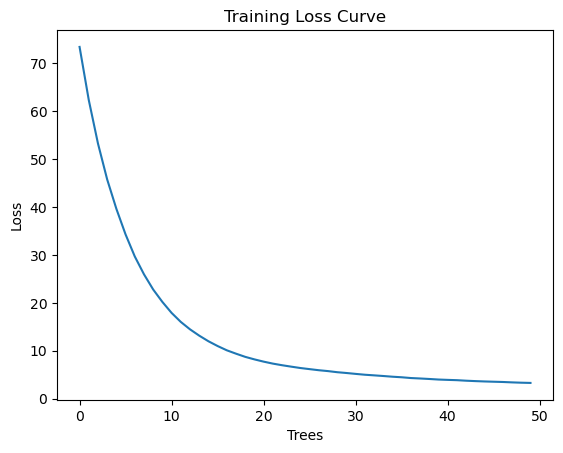

In [42]:
plt.plot(model.train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Trees")
plt.ylabel("Loss")
plt.show()
